In [1]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pymorphy2
import re

pd.set_option('display.max_columns', 500)

In [17]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


class PreprocessingEncode(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, df):
        col = ['type']
        
        OHE = OneHotEncoder(sparse=False, handle_unknown='ignore')
        
        for c in col:  
            df1 = pd.DataFrame(OHE.fit_transform(df[[c]]),
                               columns = [c + str(i) for i in range(len(df[c].value_counts()))])
            
            df1.iloc[:, 0] = df1.iloc[:, 0].astype('bool')
            df1.iloc[:, 1] = df1.iloc[:, 1].astype('bool')

            df = df.join(df1)
            df = df.drop([c], axis = 1)
            
        
        return df
    

class LabelEncode(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, df):
        level_map_exp = {'Более 6 лет' : 4, 'От 3 до 6 лет' : 3, 
                     'От 1 года до 3 лет' : 2, 'Нет опыта' : 1}
        df['experience'] = df['experience'].map(level_map_exp) 
        
        level_map_empl = {'Полная занятость' : 3, 'Частичная занятость' : 2, 
                     'Проектная работа' : 1, 'Стажировка' : 1}
        df['employment'] = df['employment'].map(level_map_empl)  
        
        
#         level_map_sched = {'Удаленная работа' : 4, 'Гибкий график' : 3, 
#                      'Сменный график' : 3, 'Полный день' : 2, 'Вахтовый метод' : 1}
#         df['schedule'] = df['schedule'].map(level_map_sched) 
        
        
        
        level_map_bil = {'Премиум' : 4, 'Стандарт плюс' : 3, 
                     'Стандарт' : 2,  'Бесплатная' : 1}
        df['billing_type'] = df['billing_type'].map(level_map_bil) 
        
        return df

    
    
class DeleteColumns(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, df):        
        col = ['insider_interview', 'vacancy_constructor_template', 'response_url', 'premium', 
               'alternate_url', 'errors', 'id', 'salary_currency', 'type',
               'negotiations_url', 'suitable_resumes_url', 'relations', 'response_letter_required', 
               'site', 'published_at', 'created_at', 'has_test', 'test', 'salary_gross', 'address_city', 
               'allow_messages', 'department', 'contacts', 'branded_description', 'code', 'hidden', 
               'accept_incomplete_resumes', 'quick_responses_allowed', 'driver_license_types', 
               'accept_handicapped', 'accept_kids', 'archived', 'apply_alternate_url', 'specializations']
        
        df = df.drop(col, axis=1)          
        return df

    
class DropNan(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, df):
        return df[df['errors'].isna()]
    
    
class TfIdfPreprocess():   
    col = []
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, df):
        vectorizer = TfidfVectorizer(
            input='content', 
            encoding='utf-8',
            decode_error='strict', 
            strip_accents=None, 
            lowercase=True,
            preprocessor=None, 
            tokenizer=None, 
            analyzer='word',
            stop_words=None, 
            min_df=5
        )
        
        df['description'] = df['description'].replace('<[^>]*>', ' ', regex = True).str.lower()
        df['description'] = df['description'].replace(' +', ' ' ,  regex = True)
        morph = pymorphy2.MorphAnalyzer()
        for i in range(len(df)):
            text = df.iloc[i]['description'] 
            new_text = re.findall(r'[А-Яа-я]+', text)

            new_descr = ''
            for word in new_text:
                new_descr += str(morph.parse(word)[0].normal_form) + ' ' 
            df['description'][i] = new_descr
       # X_tr = vectorizer.fit_transform(df[col])
        return df
    
### EXECUTE BEFORE  DeleteColumns
class CurrencyConverter(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, df):
        # Ou, you are so genious
        df = df.copy()
        df.loc[df['salary_currency'] == 'RUB', 'salary_from'] = \
                (df.loc[df['salary_currency'] == 'RUB', 'salary_from']).copy() * 0.032
       
        df.loc[df['salary_currency'] == 'RUB', 'salary_to'] = \
                (df.loc[df['salary_currency'] == 'RUB', 'salary_to']).copy() * 0.032
    
    
        df.loc[df['salary_currency'] == 'EUR', 'salary_from'] = \
                (df.loc[df['salary_currency'] == 'EUR', 'salary_from']).copy() * 2.26
       
        df.loc[df['salary_currency'] == 'EUR', 'salary_to'] = \
                (df.loc[df['salary_currency'] == 'EUR', 'salary_to']).copy() * 2.26
    
    
        df.loc[df['salary_currency'] == 'USD', 'salary_from'] = \
                (df.loc[df['salary_currency'] == 'USD', 'salary_from']).copy() * 2.05
       
        df.loc[df['salary_currency'] == 'USD', 'salary_to'] = \
                (df.loc[df['salary_currency'] == 'USD', 'salary_to']).copy() * 2.05
        
            
        return df
        
    
class ScaleFeatures(BaseEstimator, TransformerMixin):
    col = []
    
    def fit(self, x, y=None):
        return self

    def transform(self, df):
        scaler = StandardScaler()
        scaler.fit_transform(df)
        return df

    
class PreprocessingPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, intValue=0, stringParam="defaultValue", otherParam=None):
        self.intValue = intValue
        self.stringParam = stringParam

        # THIS IS WRONG! Parameters should have same name as attributes
        self.differentParam = otherParam 
        
    def fit(self, X, y=None):
        assert (type(self.intValue) == int), "intValue parameter must be integer"
        assert (type(self.stringParam) == str), "stringValue parameter must be string"
        assert (len(X) == 20), "X must be list with numerical values."

        self.treshold_ = (sum(X)/len(X)) + self.intValue  # mean + intValue

        return self

    def _meaning(self, x):
        # returns True/False according to fitted classifier
        # notice underscore on the beginning
        return( True if x >= self.treshold_ else False )

    def predict(self, X, y=None):
        try:
            getattr(self, "treshold_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        return([self._meaning(x) for x in X])

    def score(self, X, y=None):
        # counts number of values bigger than mean
        return(sum(self.predict(X))) 
    
    def transform(self, df):
        dropn = DropNan()
        df = dropn.transform(df)

        ### EXECUTE BEFORE  DeleteColumns
        cur = CurrencyConverter()
        df = cur.transform(df)
        
        delc = DeleteColumns()
        df = delc.transform(df)
        #pe = PreprocessingEncode()
        #df = pe.transform(df)
        laenc = LabelEncode()
        df = laenc.transform(df)
        #tf = TfIdfPreprocess()
        #df = tf.transform(df)       
        return df
    
    
class CatBoostModifiedRegressor(BaseEstimator, ):
    def __init__(self, *args, **kwargs):
        self.cat = CatBoostRegressor()
    
    def fit(self, x, y=None):
        indexes = []
        for a, b in enumerate(x.dtypes == 'object'):
            if b:
                indexes.append(a)
                
        self.cat_indexes = indexes
        self.cat.fit(x, y, cat_features=self.cat_indexes)
        
        return self

    def predict(self, x):        
        return self.cat.predict(x)
    
    def get_params(self, deep=True):
        return self.cat.get_params(deep)
    
    def set_params(self, **params):
        self.cat.set_params(params)

In [18]:
df2 = pd.read_csv('FULL-DATASET-11k-WITH-SPEC.csv', sep=';', low_memory=False)
df2

,id,premium,billing_type,relations,name,insider_interview,response_letter_required,area,type,allow_messages,site,experience,schedule,employment,department,contacts,description,branded_description,vacancy_constructor_template,key_skills,accept_handicapped,accept_kids,archived,response_url,specializations,code,hidden,quick_responses_allowed,driver_license_types,accept_incomplete_resumes,employer,published_at,created_at,negotiations_url,suitable_resumes_url,apply_alternate_url,has_test,test,alternate_url,errors,salary_from,salary_to,salary_gross,salary_currency,address_city,Административный персонал,Закупки,Безопасность,Страхование,Рабочий персонал,"Бухгалтерия, управленческий учет, финансы предприятия",Домашний персонал,Консультирование,"Искусство, развлечения, масс-медиа",Продажи,"Транспорт, логистика","Банки, инвестиции, лизинг",Производство,"Управление персоналом, тренинги",Добыча сырья,"Государственная служба, некоммерческие организации",Инсталляция и сервис,"Медицина, фармацевтика","Наука, образование",Автомобильный бизнес,Юристы,"Маркетинг, реклама, PR",Высший менеджмент,"Спортивные клубы, фитнес, салоны красоты","Информационные технологии, интернет, телеком","Туризм, гостиницы, рестораны","Начало карьеры, студенты","Строительство, недвижимость",Розничная торговля,Не розничная торговля
0,34671307.0,False,Бесплатная,[],Повар,NaN,False,Борисов,Открытая,True,hh.ru,От 1 года до 3 лет,Сменный график,Полная занятость,NaN,Бирская Ольга,<p><strong>Обязанности:</strong></p> <ul> <li>...,NaN,NaN,"профессионализм,Охрана труда и техника безопас...",False,False,False,NaN,"[{'id': '22.491', 'name': 'Повар', 'profarea_i...",NaN,False,False,[],True,АРТПРОДО,2019-11-21T03:15:04+0300,2019-11-21T03:15:04+0300,NaN,NaN,https://hh.ru/applicant/vacancy_response?vacan...,False,NaN,https://hh.ru/vacancy/34671307,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,34603339.0,False,Бесплатная,[],Разнорабочий,NaN,False,Молодечно,Открытая,True,hh.ru,Нет опыта,Полный день,Полная занятость,NaN,Лазарь Дмитрий,<strong>Обязанности:</strong> <ul> <li>погрузк...,NaN,NaN,"Умение работать в коллективе,Производство стро...",True,False,False,NaN,"[{'id': '29.556', 'name': 'Разнорабочий', 'pro...",NaN,False,False,[],True,АРМКОН,2019-11-17T16:59:24+0300,2019-11-17T16:59:24+0300,NaN,NaN,https://hh.ru/applicant/vacancy_response?vacan...,False,NaN,https://hh.ru/vacancy/34603339,NaN,300.0,NaN,False,BYR,Молодечно,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,34324260.0,False,Бесплатная,[],"Водитель такси Uber, Яндекс.Такси",NaN,False,Минск,Открытая,True,hh.ru,Нет опыта,Полный день,Полная занятость,NaN,Богаевскийй Дмитрий,<p>ИП Приглашает в свой небольшой штат сотрудн...,NaN,NaN,Вождение автомобилей представительского класса...,False,False,False,NaN,"[{'id': '21.17', 'name': 'Автоперевозки', 'pro...",NaN,False,False,[],True,Амальфини,2019-10-29T11:57:21+0300,2019-10-29T11:57:21+0300,NaN,NaN,https://hh.ru/applicant/vacancy_response?vacan...,False,NaN,https://hh.ru/vacancy/34324260,NaN,500.0,1500.0,True,BYR,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,34572854.0,False,Стандарт плюс,[],Ведущий инженер-энергетик,NaN,False,Жодино,Открытая,True,hh.ru,От 3 до 6 лет,Полный день,Полная занятость,NaN,Наталья,<strong>Обязанности:</strong> <ul> <li>эксплуа...,NaN,NaN,NaN,False,False,False,NaN,"[{'id': '18.153', 'name': 'Металлургия', 'prof...",NaN,False,False,[],False,Унитарное предприятие Цветмет,2019-11-23T13:28:21+0300,2019-11-23T13:28:21+0300,NaN,NaN,https://hh.ru/applicant/vacancy_response?vacan...,False,NaN,https://hh.ru/vacancy/34572854,NaN,1400.0,NaN,False,BYR,Жодино,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,34520418.0,False,Бесплатная,[],Обивщик (о

In [19]:
pipeline = PreprocessingPipeline()
#pipeline.fit(df)
df2 = pipeline.transform(df2)

In [20]:
#pd.set_option('display.max_columns', 500)
df2.head()

,billing_type,name,area,experience,schedule,employment,description,key_skills,employer,salary_from,salary_to,Административный персонал,Закупки,Безопасность,Страхование,Рабочий персонал,"Бухгалтерия, управленческий учет, финансы предприятия",Домашний персонал,Консультирование,"Искусство, развлечения, масс-медиа",Продажи,"Транспорт, логистика","Банки, инвестиции, лизинг",Производство,"Управление персоналом, тренинги",Добыча сырья,"Государственная служба, некоммерческие организации",Инсталляция и сервис,"Медицина, фармацевтика","Наука, образование",Автомобильный бизнес,Юристы,"Маркетинг, реклама, PR",Высший менеджмент,"Спортивные клубы, фитнес, салоны красоты","Информационные технологии, интернет, телеком","Туризм, гостиницы, рестораны","Начало карьеры, студенты","Строительство, недвижимость",Розничная торговля,Не розничная торговля
0,1,Повар,Борисов,2,Сменный график,3,<p><strong>Обязанности:</strong></p> <ul> <li>...,"профессионализм,Охрана труда и техника безопас...",АРТПРОДО,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,Разнорабочий,Молодечно,1,Полный день,3,<strong>Обязанности:</strong> <ul> <li>погрузк...,"Умение работать в коллективе,Производство стро...",АРМКОН,300.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,"Водитель такси Uber, Яндекс.Такси",Минск,1,Полный день,3,<p>ИП Приглашает в свой небольшой штат сотрудн...,Вождение автомобилей представительского класса...,Амальфини,500.0,1500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,Ведущий инженер-энергетик,Жодино,3,Полный день,3,<strong>Обязанности:</strong> <ul> <li>эксплуа...,NaN,Унитарное предприятие Цветмет,1400.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,Обивщик (обойщик мягкой мебели),Минск,1,Полный день,3,<p><strong>Требования:</strong></p> <ul> <li>Ж...,NaN,ПанДиван,1200.0,1600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
from catboost import CatBoostRegressor,  Pool, cv
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.model_selection import train_test_split, validation_curve, learning_curve

In [22]:
cat = CatBoostModifiedRegressor()
df = df2

In [48]:
X = df.drop(['salary_from', 'salary_to', 'description'], axis=1)
y = df['salary_from']
y2 = df['salary_to']


X1 = X[~y.isna()]
y = y[~y.isna()]

X2 = X[~y2.isna()]
y2 = y2[~y2.isna()]


X1 = X1.fillna('NaN')
X2 = X2.fillna('NaN')

X1.drop(['schedule'], inplace=True, axis=1)

mask = y < 30000
X1 = X1[mask]
y = y[mask]

mask2 = y2 < 23000
X2 = X2[mask2]
y2 = y2[mask2]


X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.1, shuffle=True, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.1, shuffle=True, random_state=42)

len(X1), len(X2)

(7134, 3306)

In [49]:
y_train2.describe()

count     2975.000000
mean      1188.239244
std        925.554266
min         82.000000
25%        700.000000
50%       1000.000000
75%       1500.000000
max      20000.000000
Name: salary_to, dtype: float64

In [50]:
y_test2.describe()

count     331.000000
mean     1155.203927
std       857.526984
min       200.000000
25%       650.000000
50%       860.000000
75%      1460.000000
max      6150.000000
Name: salary_to, dtype: float64

In [51]:
cat = CatBoostModifiedRegressor()

In [52]:
cat.fit(X_train, y_train) # if needed

0:	learn: 2197.0986471	total: 72.9ms	remaining: 1m 12s
1:	learn: 2178.0638939	total: 150ms	remaining: 1m 14s
2:	learn: 2160.6319345	total: 194ms	remaining: 1m 4s
3:	learn: 2141.8101902	total: 214ms	remaining: 53.3s
4:	learn: 2122.9606552	total: 226ms	remaining: 44.9s
5:	learn: 2106.8490849	total: 253ms	remaining: 41.9s
6:	learn: 2087.4608745	total: 272ms	remaining: 38.6s
7:	learn: 2072.1854932	total: 287ms	remaining: 35.6s
8:	learn: 2042.2877838	total: 306ms	remaining: 33.7s
9:	learn: 2030.6498925	total: 316ms	remaining: 31.3s
10:	learn: 2017.8901458	total: 329ms	remaining: 29.6s
11:	learn: 2001.6762465	total: 336ms	remaining: 27.7s
12:	learn: 1975.5418408	total: 345ms	remaining: 26.2s
13:	learn: 1956.6356552	total: 351ms	remaining: 24.7s
14:	learn: 1943.3288089	total: 361ms	remaining: 23.7s
15:	learn: 1932.5981175	total: 372ms	remaining: 22.8s
16:	learn: 1908.7910928	total: 385ms	remaining: 22.3s
17:	learn: 1895.4740678	total: 393ms	remaining: 21.4s
18:	learn: 1881.5960065	total: 404m

153:	learn: 1091.5277268	total: 2.11s	remaining: 11.6s
154:	learn: 1091.1287902	total: 2.13s	remaining: 11.6s
155:	learn: 1090.2144587	total: 2.14s	remaining: 11.6s
156:	learn: 1089.3460747	total: 2.16s	remaining: 11.6s
157:	learn: 1087.3738111	total: 2.17s	remaining: 11.6s
158:	learn: 1086.2819361	total: 2.18s	remaining: 11.6s
159:	learn: 1084.3366305	total: 2.2s	remaining: 11.5s
160:	learn: 1083.8700940	total: 2.21s	remaining: 11.5s
161:	learn: 1082.8028355	total: 2.23s	remaining: 11.5s
162:	learn: 1080.1744760	total: 2.24s	remaining: 11.5s
163:	learn: 1080.0656289	total: 2.25s	remaining: 11.5s
164:	learn: 1078.0884568	total: 2.26s	remaining: 11.4s
165:	learn: 1076.3134350	total: 2.27s	remaining: 11.4s
166:	learn: 1074.2252711	total: 2.28s	remaining: 11.4s
167:	learn: 1073.2509967	total: 2.29s	remaining: 11.4s
168:	learn: 1072.2200131	total: 2.31s	remaining: 11.3s
169:	learn: 1068.9530201	total: 2.32s	remaining: 11.3s
170:	learn: 1066.7915012	total: 2.33s	remaining: 11.3s
171:	learn:

309:	learn: 947.3243649	total: 4.51s	remaining: 10s
310:	learn: 944.6380143	total: 4.52s	remaining: 10s
311:	learn: 944.2732150	total: 4.54s	remaining: 10s
312:	learn: 944.1433857	total: 4.56s	remaining: 10s
313:	learn: 943.1653333	total: 4.58s	remaining: 10s
314:	learn: 942.9222937	total: 4.61s	remaining: 10s
315:	learn: 942.2469490	total: 4.63s	remaining: 10s
316:	learn: 941.5633778	total: 4.63s	remaining: 9.98s
317:	learn: 940.2969415	total: 4.66s	remaining: 9.99s
318:	learn: 939.6661306	total: 4.68s	remaining: 9.99s
319:	learn: 939.2136352	total: 4.7s	remaining: 9.99s
320:	learn: 937.3927553	total: 4.72s	remaining: 9.98s
321:	learn: 937.3421806	total: 4.75s	remaining: 10s
322:	learn: 936.9111972	total: 4.77s	remaining: 10s
323:	learn: 936.8823567	total: 4.78s	remaining: 9.97s
324:	learn: 936.8123916	total: 4.8s	remaining: 9.96s
325:	learn: 936.2408875	total: 4.81s	remaining: 9.95s
326:	learn: 936.2092337	total: 4.82s	remaining: 9.93s
327:	learn: 935.8130800	total: 4.84s	remaining: 

468:	learn: 864.8518073	total: 6.67s	remaining: 7.55s
469:	learn: 864.6318513	total: 6.68s	remaining: 7.53s
470:	learn: 864.5088152	total: 6.68s	remaining: 7.51s
471:	learn: 863.3108427	total: 6.69s	remaining: 7.49s
472:	learn: 863.1257858	total: 6.7s	remaining: 7.47s
473:	learn: 862.9935380	total: 6.72s	remaining: 7.46s
474:	learn: 861.8891999	total: 6.73s	remaining: 7.44s
475:	learn: 861.1220701	total: 6.75s	remaining: 7.43s
476:	learn: 861.0488905	total: 6.76s	remaining: 7.41s
477:	learn: 860.9325927	total: 6.77s	remaining: 7.4s
478:	learn: 860.2947543	total: 6.78s	remaining: 7.37s
479:	learn: 859.9563286	total: 6.79s	remaining: 7.36s
480:	learn: 858.8182840	total: 6.8s	remaining: 7.34s
481:	learn: 857.9510893	total: 6.8s	remaining: 7.31s
482:	learn: 857.8769230	total: 6.82s	remaining: 7.3s
483:	learn: 857.7522624	total: 6.83s	remaining: 7.28s
484:	learn: 857.5863551	total: 6.84s	remaining: 7.26s
485:	learn: 856.4398306	total: 6.85s	remaining: 7.25s
486:	learn: 856.3897763	total: 6.

635:	learn: 816.0780880	total: 8.86s	remaining: 5.07s
636:	learn: 816.0436291	total: 8.87s	remaining: 5.05s
637:	learn: 815.7547643	total: 8.88s	remaining: 5.04s
638:	learn: 815.7026197	total: 8.9s	remaining: 5.03s
639:	learn: 815.5558933	total: 8.91s	remaining: 5.01s
640:	learn: 815.4370970	total: 8.92s	remaining: 5s
641:	learn: 814.7103714	total: 8.93s	remaining: 4.98s
642:	learn: 814.4390340	total: 8.94s	remaining: 4.96s
643:	learn: 814.3717841	total: 8.95s	remaining: 4.95s
644:	learn: 814.3512696	total: 8.96s	remaining: 4.93s
645:	learn: 814.1186984	total: 8.98s	remaining: 4.92s
646:	learn: 813.4171307	total: 8.99s	remaining: 4.9s
647:	learn: 813.3946836	total: 9.01s	remaining: 4.89s
648:	learn: 813.3729764	total: 9.01s	remaining: 4.87s
649:	learn: 812.9002554	total: 9.02s	remaining: 4.86s
650:	learn: 812.3606245	total: 9.03s	remaining: 4.84s
651:	learn: 812.1946900	total: 9.04s	remaining: 4.83s
652:	learn: 811.9735061	total: 9.06s	remaining: 4.81s
653:	learn: 811.8664719	total: 9.

795:	learn: 782.6262942	total: 10.9s	remaining: 2.79s
796:	learn: 782.5466363	total: 10.9s	remaining: 2.77s
797:	learn: 782.5330994	total: 10.9s	remaining: 2.76s
798:	learn: 781.9474602	total: 10.9s	remaining: 2.75s
799:	learn: 781.2859489	total: 10.9s	remaining: 2.73s
800:	learn: 781.1968987	total: 11s	remaining: 2.72s
801:	learn: 781.0378225	total: 11s	remaining: 2.71s
802:	learn: 780.9869807	total: 11s	remaining: 2.7s
803:	learn: 780.9629639	total: 11s	remaining: 2.68s
804:	learn: 780.9511693	total: 11s	remaining: 2.67s
805:	learn: 780.8857673	total: 11s	remaining: 2.66s
806:	learn: 780.7310341	total: 11.1s	remaining: 2.64s
807:	learn: 780.6924473	total: 11.1s	remaining: 2.63s
808:	learn: 780.6675175	total: 11.1s	remaining: 2.62s
809:	learn: 780.6520868	total: 11.1s	remaining: 2.6s
810:	learn: 780.5150928	total: 11.1s	remaining: 2.59s
811:	learn: 779.9396989	total: 11.1s	remaining: 2.57s
812:	learn: 779.8605367	total: 11.1s	remaining: 2.56s
813:	learn: 779.8250808	total: 11.1s	remai

949:	learn: 754.9701139	total: 12.9s	remaining: 678ms
950:	learn: 754.8853186	total: 12.9s	remaining: 665ms
951:	learn: 754.8560594	total: 12.9s	remaining: 651ms
952:	learn: 754.8076633	total: 12.9s	remaining: 637ms
953:	learn: 754.7166829	total: 12.9s	remaining: 624ms
954:	learn: 754.5065384	total: 12.9s	remaining: 610ms
955:	learn: 754.2812364	total: 13s	remaining: 596ms
956:	learn: 754.2246131	total: 13s	remaining: 583ms
957:	learn: 754.1423963	total: 13s	remaining: 569ms
958:	learn: 754.1141038	total: 13s	remaining: 556ms
959:	learn: 754.0687843	total: 13s	remaining: 542ms
960:	learn: 754.0462746	total: 13s	remaining: 528ms
961:	learn: 753.7579650	total: 13s	remaining: 515ms
962:	learn: 753.7454833	total: 13s	remaining: 501ms
963:	learn: 753.5559436	total: 13.1s	remaining: 488ms
964:	learn: 753.2760991	total: 13.1s	remaining: 474ms
965:	learn: 753.0202986	total: 13.1s	remaining: 460ms
966:	learn: 752.9185573	total: 13.1s	remaining: 447ms
967:	learn: 752.8858519	total: 13.1s	remaini

CatBoostModifiedRegressor(loss_function='RMSE')

In [53]:
r2_score(y_test, cat.predict(X_test))

0.9265290041204619

In [54]:
cat = CatBoostModifiedRegressor()

In [60]:
cross_val_score(estimator=cat, X=X_train, y=y_train, cv=KFold(5, shuffle=True, random_state=42), scoring='r2').mean()

0:	learn: 2202.7165753	total: 57.2ms	remaining: 57.1s
1:	learn: 2182.5005513	total: 91.8ms	remaining: 45.8s
2:	learn: 2161.4082253	total: 137ms	remaining: 45.4s
3:	learn: 2138.5935852	total: 158ms	remaining: 39.4s
4:	learn: 2122.3908231	total: 184ms	remaining: 36.6s
5:	learn: 2108.0678266	total: 193ms	remaining: 31.9s
6:	learn: 2092.9178427	total: 202ms	remaining: 28.6s
7:	learn: 2072.5231413	total: 209ms	remaining: 26s
8:	learn: 2051.8849497	total: 220ms	remaining: 24.2s
9:	learn: 2032.5212553	total: 228ms	remaining: 22.6s
10:	learn: 2009.2978711	total: 236ms	remaining: 21.2s
11:	learn: 1992.7290916	total: 253ms	remaining: 20.8s
12:	learn: 1973.8811655	total: 271ms	remaining: 20.5s
13:	learn: 1959.3333429	total: 291ms	remaining: 20.5s
14:	learn: 1944.3128346	total: 306ms	remaining: 20.1s
15:	learn: 1926.6160539	total: 313ms	remaining: 19.2s
16:	learn: 1907.9288019	total: 318ms	remaining: 18.4s
17:	learn: 1891.6041670	total: 324ms	remaining: 17.7s
18:	learn: 1881.4983274	total: 330ms	r

157:	learn: 1042.6081453	total: 2.12s	remaining: 11.3s
158:	learn: 1042.3059261	total: 2.14s	remaining: 11.3s
159:	learn: 1039.8633627	total: 2.16s	remaining: 11.3s
160:	learn: 1038.7984404	total: 2.17s	remaining: 11.3s
161:	learn: 1037.2421006	total: 2.2s	remaining: 11.4s
162:	learn: 1035.6931093	total: 2.22s	remaining: 11.4s
163:	learn: 1035.3817246	total: 2.23s	remaining: 11.3s
164:	learn: 1034.1231962	total: 2.24s	remaining: 11.3s
165:	learn: 1031.9589916	total: 2.25s	remaining: 11.3s
166:	learn: 1030.4206787	total: 2.26s	remaining: 11.3s
167:	learn: 1028.8106863	total: 2.27s	remaining: 11.2s
168:	learn: 1028.5763332	total: 2.28s	remaining: 11.2s
169:	learn: 1028.3392678	total: 2.29s	remaining: 11.2s
170:	learn: 1025.7943399	total: 2.31s	remaining: 11.2s
171:	learn: 1024.5694508	total: 2.31s	remaining: 11.1s
172:	learn: 1021.4540586	total: 2.33s	remaining: 11.1s
173:	learn: 1019.6265112	total: 2.34s	remaining: 11.1s
174:	learn: 1018.2840551	total: 2.35s	remaining: 11.1s
175:	learn:

318:	learn: 894.2559442	total: 3.96s	remaining: 8.47s
319:	learn: 894.0695115	total: 3.97s	remaining: 8.45s
320:	learn: 893.2983095	total: 3.99s	remaining: 8.44s
321:	learn: 893.1444494	total: 3.99s	remaining: 8.41s
322:	learn: 892.2327296	total: 4s	remaining: 8.38s
323:	learn: 891.8877693	total: 4.01s	remaining: 8.38s
324:	learn: 891.1902905	total: 4.03s	remaining: 8.36s
325:	learn: 890.8026177	total: 4.04s	remaining: 8.35s
326:	learn: 890.3389056	total: 4.05s	remaining: 8.34s
327:	learn: 890.1881751	total: 4.06s	remaining: 8.31s
328:	learn: 889.3419914	total: 4.07s	remaining: 8.3s
329:	learn: 889.0285038	total: 4.08s	remaining: 8.28s
330:	learn: 888.7028652	total: 4.08s	remaining: 8.26s
331:	learn: 888.4122552	total: 4.09s	remaining: 8.23s
332:	learn: 888.0393053	total: 4.1s	remaining: 8.21s
333:	learn: 887.4485338	total: 4.11s	remaining: 8.19s
334:	learn: 887.0930436	total: 4.11s	remaining: 8.16s
335:	learn: 886.3749854	total: 4.12s	remaining: 8.14s
336:	learn: 885.6136750	total: 4.

488:	learn: 813.0992240	total: 5.75s	remaining: 6.01s
489:	learn: 812.9141973	total: 5.76s	remaining: 5.99s
490:	learn: 812.6014266	total: 5.77s	remaining: 5.98s
491:	learn: 812.4707719	total: 5.78s	remaining: 5.97s
492:	learn: 811.9302507	total: 5.79s	remaining: 5.96s
493:	learn: 811.5663190	total: 5.8s	remaining: 5.95s
494:	learn: 811.1739845	total: 5.82s	remaining: 5.94s
495:	learn: 810.7280380	total: 5.83s	remaining: 5.92s
496:	learn: 810.4382434	total: 5.84s	remaining: 5.91s
497:	learn: 810.1529275	total: 5.84s	remaining: 5.89s
498:	learn: 810.0266086	total: 5.85s	remaining: 5.87s
499:	learn: 809.8314584	total: 5.85s	remaining: 5.85s
500:	learn: 809.5509111	total: 5.86s	remaining: 5.84s
501:	learn: 809.4563382	total: 5.87s	remaining: 5.82s
502:	learn: 808.4802861	total: 5.88s	remaining: 5.81s
503:	learn: 808.3811641	total: 5.89s	remaining: 5.8s
504:	learn: 807.7237086	total: 5.9s	remaining: 5.78s
505:	learn: 807.4875890	total: 5.91s	remaining: 5.77s
506:	learn: 807.0766671	total: 

649:	learn: 757.2322081	total: 7.4s	remaining: 3.98s
650:	learn: 757.1520473	total: 7.4s	remaining: 3.97s
651:	learn: 756.5475080	total: 7.42s	remaining: 3.96s
652:	learn: 755.9575479	total: 7.42s	remaining: 3.94s
653:	learn: 755.7856867	total: 7.43s	remaining: 3.93s
654:	learn: 755.6735187	total: 7.44s	remaining: 3.92s
655:	learn: 755.3777695	total: 7.46s	remaining: 3.91s
656:	learn: 754.8311561	total: 7.46s	remaining: 3.9s
657:	learn: 754.4669408	total: 7.47s	remaining: 3.88s
658:	learn: 754.2257561	total: 7.48s	remaining: 3.87s
659:	learn: 754.1198823	total: 7.49s	remaining: 3.86s
660:	learn: 753.5355070	total: 7.49s	remaining: 3.84s
661:	learn: 753.0013823	total: 7.5s	remaining: 3.83s
662:	learn: 752.9638259	total: 7.51s	remaining: 3.82s
663:	learn: 752.7636791	total: 7.53s	remaining: 3.81s
664:	learn: 752.5698842	total: 7.54s	remaining: 3.8s
665:	learn: 752.0021017	total: 7.55s	remaining: 3.78s
666:	learn: 751.5552020	total: 7.56s	remaining: 3.77s
667:	learn: 751.3646379	total: 7.

804:	learn: 716.1605001	total: 9.23s	remaining: 2.24s
805:	learn: 715.9419737	total: 9.25s	remaining: 2.23s
806:	learn: 715.7604156	total: 9.25s	remaining: 2.21s
807:	learn: 715.5690680	total: 9.26s	remaining: 2.2s
808:	learn: 715.3778675	total: 9.27s	remaining: 2.19s
809:	learn: 715.2548679	total: 9.28s	remaining: 2.18s
810:	learn: 715.0629852	total: 9.29s	remaining: 2.17s
811:	learn: 714.9072839	total: 9.3s	remaining: 2.15s
812:	learn: 714.8485412	total: 9.31s	remaining: 2.14s
813:	learn: 714.7311719	total: 9.33s	remaining: 2.13s
814:	learn: 714.5573359	total: 9.34s	remaining: 2.12s
815:	learn: 714.3864771	total: 9.35s	remaining: 2.11s
816:	learn: 714.2900237	total: 9.36s	remaining: 2.1s
817:	learn: 713.9493586	total: 9.37s	remaining: 2.08s
818:	learn: 713.7987474	total: 9.38s	remaining: 2.07s
819:	learn: 713.1531787	total: 9.4s	remaining: 2.06s
820:	learn: 712.6492508	total: 9.44s	remaining: 2.06s
821:	learn: 712.4854002	total: 9.47s	remaining: 2.05s
822:	learn: 712.2421977	total: 9

959:	learn: 687.6478719	total: 11.1s	remaining: 464ms
960:	learn: 687.5111223	total: 11.1s	remaining: 452ms
961:	learn: 687.4470061	total: 11.2s	remaining: 441ms
962:	learn: 687.3050728	total: 11.2s	remaining: 429ms
963:	learn: 687.2553896	total: 11.2s	remaining: 418ms
964:	learn: 687.0184803	total: 11.2s	remaining: 408ms
965:	learn: 686.8414000	total: 11.3s	remaining: 396ms
966:	learn: 686.6648845	total: 11.3s	remaining: 385ms
967:	learn: 686.5973443	total: 11.3s	remaining: 374ms
968:	learn: 686.4646075	total: 11.4s	remaining: 363ms
969:	learn: 686.1113343	total: 11.4s	remaining: 352ms
970:	learn: 686.0776171	total: 11.4s	remaining: 340ms
971:	learn: 685.9917141	total: 11.4s	remaining: 329ms
972:	learn: 685.8175175	total: 11.4s	remaining: 317ms
973:	learn: 685.5637254	total: 11.4s	remaining: 305ms
974:	learn: 685.4907033	total: 11.4s	remaining: 293ms
975:	learn: 685.2459761	total: 11.4s	remaining: 281ms
976:	learn: 685.0849203	total: 11.5s	remaining: 270ms
977:	learn: 684.8463181	tota

116:	learn: 1100.0906721	total: 1.13s	remaining: 8.5s
117:	learn: 1097.2459317	total: 1.14s	remaining: 8.49s
118:	learn: 1094.4578961	total: 1.15s	remaining: 8.48s
119:	learn: 1093.8899790	total: 1.15s	remaining: 8.46s
120:	learn: 1092.2142541	total: 1.16s	remaining: 8.42s
121:	learn: 1089.8205289	total: 1.17s	remaining: 8.43s
122:	learn: 1088.1258163	total: 1.19s	remaining: 8.45s
123:	learn: 1084.9497772	total: 1.2s	remaining: 8.46s
124:	learn: 1082.3595662	total: 1.21s	remaining: 8.47s
125:	learn: 1080.7348699	total: 1.23s	remaining: 8.55s
126:	learn: 1079.3867337	total: 1.26s	remaining: 8.67s
127:	learn: 1075.5804553	total: 1.28s	remaining: 8.73s
128:	learn: 1074.1384692	total: 1.3s	remaining: 8.77s
129:	learn: 1072.3718406	total: 1.33s	remaining: 8.93s
130:	learn: 1069.1346544	total: 1.34s	remaining: 8.93s
131:	learn: 1067.5670429	total: 1.36s	remaining: 8.95s
132:	learn: 1066.2481297	total: 1.37s	remaining: 8.93s
133:	learn: 1062.7304895	total: 1.38s	remaining: 8.93s
134:	learn: 1

269:	learn: 911.5528879	total: 3s	remaining: 8.11s
270:	learn: 911.1368330	total: 3.01s	remaining: 8.1s
271:	learn: 909.6202452	total: 3.03s	remaining: 8.1s
272:	learn: 908.4955877	total: 3.04s	remaining: 8.09s
273:	learn: 906.6209452	total: 3.05s	remaining: 8.07s
274:	learn: 906.1566819	total: 3.06s	remaining: 8.06s
275:	learn: 904.9407385	total: 3.06s	remaining: 8.04s
276:	learn: 904.2595245	total: 3.07s	remaining: 8.01s
277:	learn: 903.2913046	total: 3.08s	remaining: 8s
278:	learn: 902.2062621	total: 3.09s	remaining: 7.99s
279:	learn: 901.4515958	total: 3.1s	remaining: 7.98s
280:	learn: 901.3807786	total: 3.11s	remaining: 7.95s
281:	learn: 901.1962942	total: 3.11s	remaining: 7.93s
282:	learn: 901.0317750	total: 3.12s	remaining: 7.91s
283:	learn: 900.6817153	total: 3.14s	remaining: 7.91s
284:	learn: 899.7860107	total: 3.15s	remaining: 7.91s
285:	learn: 899.6824103	total: 3.17s	remaining: 7.91s
286:	learn: 899.5475235	total: 3.18s	remaining: 7.9s
287:	learn: 898.9115669	total: 3.19s	r

422:	learn: 853.8597413	total: 4.54s	remaining: 6.2s
423:	learn: 853.8353410	total: 4.55s	remaining: 6.18s
424:	learn: 853.7673449	total: 4.56s	remaining: 6.16s
425:	learn: 853.2637265	total: 4.57s	remaining: 6.16s
426:	learn: 853.2141207	total: 4.58s	remaining: 6.14s
427:	learn: 852.8787090	total: 4.58s	remaining: 6.12s
428:	learn: 852.7024789	total: 4.59s	remaining: 6.11s
429:	learn: 852.2177748	total: 4.6s	remaining: 6.09s
430:	learn: 852.1882515	total: 4.6s	remaining: 6.08s
431:	learn: 852.1672053	total: 4.61s	remaining: 6.06s
432:	learn: 852.0095766	total: 4.61s	remaining: 6.04s
433:	learn: 851.8272402	total: 4.62s	remaining: 6.02s
434:	learn: 851.6505428	total: 4.63s	remaining: 6.01s
435:	learn: 851.4879079	total: 4.63s	remaining: 5.99s
436:	learn: 851.0238440	total: 4.63s	remaining: 5.97s
437:	learn: 850.5792317	total: 4.64s	remaining: 5.95s
438:	learn: 849.8555122	total: 4.65s	remaining: 5.94s
439:	learn: 849.7098004	total: 4.65s	remaining: 5.92s
440:	learn: 849.0042300	total: 

588:	learn: 822.6329302	total: 5.79s	remaining: 4.04s
589:	learn: 822.5296901	total: 5.81s	remaining: 4.03s
590:	learn: 822.1617439	total: 5.81s	remaining: 4.02s
591:	learn: 822.0513081	total: 5.82s	remaining: 4.01s
592:	learn: 821.9467054	total: 5.83s	remaining: 4s
593:	learn: 821.5939018	total: 5.83s	remaining: 3.99s
594:	learn: 821.5615476	total: 5.84s	remaining: 3.98s
595:	learn: 821.5237552	total: 5.85s	remaining: 3.96s
596:	learn: 820.6425489	total: 5.85s	remaining: 3.95s
597:	learn: 820.6194598	total: 5.86s	remaining: 3.94s
598:	learn: 819.7132188	total: 5.86s	remaining: 3.92s
599:	learn: 818.9788045	total: 5.88s	remaining: 3.92s
600:	learn: 818.8773383	total: 5.89s	remaining: 3.91s
601:	learn: 818.5562612	total: 5.9s	remaining: 3.9s
602:	learn: 818.5193979	total: 5.91s	remaining: 3.89s
603:	learn: 818.4131944	total: 5.92s	remaining: 3.88s
604:	learn: 818.0571320	total: 5.92s	remaining: 3.87s
605:	learn: 817.9892907	total: 5.94s	remaining: 3.86s
606:	learn: 817.9542369	total: 5.

762:	learn: 787.2967440	total: 7.42s	remaining: 2.31s
763:	learn: 787.1429701	total: 7.43s	remaining: 2.29s
764:	learn: 786.8994933	total: 7.43s	remaining: 2.28s
765:	learn: 786.6422633	total: 7.44s	remaining: 2.27s
766:	learn: 786.2540182	total: 7.45s	remaining: 2.26s
767:	learn: 786.2363828	total: 7.47s	remaining: 2.25s
768:	learn: 786.0023887	total: 7.47s	remaining: 2.24s
769:	learn: 785.8123710	total: 7.48s	remaining: 2.23s
770:	learn: 785.6166262	total: 7.49s	remaining: 2.22s
771:	learn: 784.9970462	total: 7.5s	remaining: 2.21s
772:	learn: 784.9799925	total: 7.51s	remaining: 2.21s
773:	learn: 784.3767452	total: 7.53s	remaining: 2.2s
774:	learn: 784.1746555	total: 7.54s	remaining: 2.19s
775:	learn: 783.6940647	total: 7.54s	remaining: 2.18s
776:	learn: 783.1316635	total: 7.57s	remaining: 2.17s
777:	learn: 782.9903253	total: 7.58s	remaining: 2.16s
778:	learn: 782.5654379	total: 7.62s	remaining: 2.16s
779:	learn: 782.5506102	total: 7.65s	remaining: 2.16s
780:	learn: 781.8541829	total:

916:	learn: 752.2835729	total: 9.26s	remaining: 838ms
917:	learn: 752.1891154	total: 9.27s	remaining: 828ms
918:	learn: 752.1466656	total: 9.29s	remaining: 819ms
919:	learn: 751.9955463	total: 9.31s	remaining: 810ms
920:	learn: 751.9675549	total: 9.33s	remaining: 800ms
921:	learn: 751.8859320	total: 9.34s	remaining: 790ms
922:	learn: 751.6973445	total: 9.35s	remaining: 780ms
923:	learn: 751.6179881	total: 9.36s	remaining: 770ms
924:	learn: 751.3021411	total: 9.38s	remaining: 761ms
925:	learn: 750.9353038	total: 9.4s	remaining: 751ms
926:	learn: 750.7289298	total: 9.42s	remaining: 742ms
927:	learn: 750.5447042	total: 9.44s	remaining: 732ms
928:	learn: 750.0579375	total: 9.47s	remaining: 724ms
929:	learn: 750.0368881	total: 9.51s	remaining: 716ms
930:	learn: 749.6772000	total: 9.57s	remaining: 710ms
931:	learn: 749.6025590	total: 9.6s	remaining: 700ms
932:	learn: 749.4230659	total: 9.61s	remaining: 690ms
933:	learn: 749.2258351	total: 9.61s	remaining: 679ms
934:	learn: 749.0790113	total:

69:	learn: 1382.8518489	total: 933ms	remaining: 12.4s
70:	learn: 1377.6730532	total: 948ms	remaining: 12.4s
71:	learn: 1374.0121636	total: 961ms	remaining: 12.4s
72:	learn: 1368.4041512	total: 970ms	remaining: 12.3s
73:	learn: 1363.7374470	total: 982ms	remaining: 12.3s
74:	learn: 1361.3786376	total: 992ms	remaining: 12.2s
75:	learn: 1357.6033321	total: 1.01s	remaining: 12.2s
76:	learn: 1353.4405918	total: 1.02s	remaining: 12.3s
77:	learn: 1347.3899179	total: 1.04s	remaining: 12.3s
78:	learn: 1342.5554662	total: 1.05s	remaining: 12.3s
79:	learn: 1338.1032131	total: 1.06s	remaining: 12.3s
80:	learn: 1332.6662320	total: 1.07s	remaining: 12.2s
81:	learn: 1327.1888068	total: 1.09s	remaining: 12.3s
82:	learn: 1321.5640343	total: 1.11s	remaining: 12.3s
83:	learn: 1319.2180770	total: 1.12s	remaining: 12.2s
84:	learn: 1314.8694376	total: 1.13s	remaining: 12.1s
85:	learn: 1311.5116239	total: 1.14s	remaining: 12.1s
86:	learn: 1305.2220710	total: 1.14s	remaining: 12s
87:	learn: 1301.5391304	total:

223:	learn: 996.3001398	total: 3.11s	remaining: 10.8s
224:	learn: 995.2920044	total: 3.13s	remaining: 10.8s
225:	learn: 995.0567691	total: 3.15s	remaining: 10.8s
226:	learn: 994.4976607	total: 3.16s	remaining: 10.8s
227:	learn: 994.1599684	total: 3.19s	remaining: 10.8s
228:	learn: 992.5873844	total: 3.2s	remaining: 10.8s
229:	learn: 992.0976046	total: 3.22s	remaining: 10.8s
230:	learn: 991.0285557	total: 3.23s	remaining: 10.8s
231:	learn: 989.7389948	total: 3.25s	remaining: 10.8s
232:	learn: 989.4989092	total: 3.27s	remaining: 10.8s
233:	learn: 989.2229101	total: 3.3s	remaining: 10.8s
234:	learn: 988.3369365	total: 3.32s	remaining: 10.8s
235:	learn: 987.7077129	total: 3.33s	remaining: 10.8s
236:	learn: 987.2837912	total: 3.35s	remaining: 10.8s
237:	learn: 986.5251404	total: 3.37s	remaining: 10.8s
238:	learn: 984.7102575	total: 3.4s	remaining: 10.8s
239:	learn: 983.4593738	total: 3.42s	remaining: 10.8s
240:	learn: 982.8783817	total: 3.44s	remaining: 10.8s
241:	learn: 981.6905810	total: 

381:	learn: 857.2512233	total: 5.29s	remaining: 8.56s
382:	learn: 855.3735829	total: 5.3s	remaining: 8.54s
383:	learn: 854.4592366	total: 5.32s	remaining: 8.53s
384:	learn: 853.3318523	total: 5.33s	remaining: 8.51s
385:	learn: 851.8407026	total: 5.33s	remaining: 8.48s
386:	learn: 851.2737449	total: 5.34s	remaining: 8.46s
387:	learn: 850.6170307	total: 5.36s	remaining: 8.45s
388:	learn: 849.9791704	total: 5.36s	remaining: 8.42s
389:	learn: 848.8868717	total: 5.37s	remaining: 8.39s
390:	learn: 848.3537982	total: 5.37s	remaining: 8.37s
391:	learn: 847.8546109	total: 5.38s	remaining: 8.34s
392:	learn: 847.0416823	total: 5.39s	remaining: 8.33s
393:	learn: 845.1804338	total: 5.4s	remaining: 8.3s
394:	learn: 844.4731840	total: 5.4s	remaining: 8.27s
395:	learn: 843.9938888	total: 5.41s	remaining: 8.25s
396:	learn: 842.2508675	total: 5.41s	remaining: 8.22s
397:	learn: 840.5795051	total: 5.42s	remaining: 8.2s
398:	learn: 840.3843470	total: 5.42s	remaining: 8.17s
399:	learn: 839.7194797	total: 5.

537:	learn: 772.3684377	total: 6.71s	remaining: 5.76s
538:	learn: 772.0133392	total: 6.73s	remaining: 5.75s
539:	learn: 770.8445304	total: 6.74s	remaining: 5.74s
540:	learn: 770.6162195	total: 6.75s	remaining: 5.73s
541:	learn: 770.3806213	total: 6.76s	remaining: 5.71s
542:	learn: 770.3537831	total: 6.78s	remaining: 5.7s
543:	learn: 770.0801682	total: 6.79s	remaining: 5.69s
544:	learn: 769.6763559	total: 6.8s	remaining: 5.68s
545:	learn: 769.2839074	total: 6.81s	remaining: 5.66s
546:	learn: 769.0226182	total: 6.82s	remaining: 5.64s
547:	learn: 768.1800467	total: 6.83s	remaining: 5.63s
548:	learn: 767.0657929	total: 6.84s	remaining: 5.62s
549:	learn: 766.8375008	total: 6.85s	remaining: 5.6s
550:	learn: 766.6675284	total: 6.86s	remaining: 5.59s
551:	learn: 766.2980144	total: 6.88s	remaining: 5.58s
552:	learn: 765.8910585	total: 6.89s	remaining: 5.57s
553:	learn: 765.7328318	total: 6.91s	remaining: 5.56s
554:	learn: 765.7069905	total: 6.92s	remaining: 5.55s
555:	learn: 764.6962904	total: 

704:	learn: 721.1135417	total: 8.37s	remaining: 3.5s
705:	learn: 720.9760168	total: 8.38s	remaining: 3.49s
706:	learn: 720.8642766	total: 8.38s	remaining: 3.47s
707:	learn: 720.7937389	total: 8.39s	remaining: 3.46s
708:	learn: 720.7107404	total: 8.4s	remaining: 3.45s
709:	learn: 720.0477351	total: 8.42s	remaining: 3.44s
710:	learn: 719.7201709	total: 8.43s	remaining: 3.43s
711:	learn: 719.5922600	total: 8.44s	remaining: 3.42s
712:	learn: 719.0883080	total: 8.45s	remaining: 3.4s
713:	learn: 718.9693169	total: 8.46s	remaining: 3.39s
714:	learn: 718.3714236	total: 8.48s	remaining: 3.38s
715:	learn: 718.2804464	total: 8.49s	remaining: 3.37s
716:	learn: 718.1587895	total: 8.49s	remaining: 3.35s
717:	learn: 718.0017745	total: 8.5s	remaining: 3.34s
718:	learn: 717.4180933	total: 8.51s	remaining: 3.33s
719:	learn: 717.3794797	total: 8.52s	remaining: 3.31s
720:	learn: 717.1184390	total: 8.54s	remaining: 3.3s
721:	learn: 717.0626689	total: 8.55s	remaining: 3.29s
722:	learn: 716.9265503	total: 8.

868:	learn: 681.6278071	total: 10.2s	remaining: 1.54s
869:	learn: 681.3390137	total: 10.2s	remaining: 1.53s
870:	learn: 681.0526078	total: 10.3s	remaining: 1.52s
871:	learn: 680.6822440	total: 10.3s	remaining: 1.51s
872:	learn: 680.2771810	total: 10.3s	remaining: 1.5s
873:	learn: 680.1398334	total: 10.3s	remaining: 1.48s
874:	learn: 680.0700280	total: 10.3s	remaining: 1.47s
875:	learn: 680.0327566	total: 10.3s	remaining: 1.46s
876:	learn: 679.6732287	total: 10.3s	remaining: 1.45s
877:	learn: 679.4883204	total: 10.3s	remaining: 1.43s
878:	learn: 679.4028695	total: 10.3s	remaining: 1.42s
879:	learn: 679.1260995	total: 10.3s	remaining: 1.41s
880:	learn: 678.8826958	total: 10.4s	remaining: 1.4s
881:	learn: 678.8473481	total: 10.4s	remaining: 1.39s
882:	learn: 678.7993839	total: 10.4s	remaining: 1.37s
883:	learn: 678.5135936	total: 10.4s	remaining: 1.36s
884:	learn: 678.5032292	total: 10.4s	remaining: 1.35s
885:	learn: 678.3767397	total: 10.4s	remaining: 1.34s
886:	learn: 678.0492452	total:

36:	learn: 1517.8914665	total: 420ms	remaining: 10.9s
37:	learn: 1509.3966096	total: 432ms	remaining: 10.9s
38:	learn: 1498.1874294	total: 443ms	remaining: 10.9s
39:	learn: 1486.6007758	total: 452ms	remaining: 10.9s
40:	learn: 1475.2636152	total: 460ms	remaining: 10.8s
41:	learn: 1462.5564089	total: 466ms	remaining: 10.6s
42:	learn: 1455.5164925	total: 471ms	remaining: 10.5s
43:	learn: 1447.0581424	total: 479ms	remaining: 10.4s
44:	learn: 1436.4367596	total: 488ms	remaining: 10.3s
45:	learn: 1426.3691286	total: 493ms	remaining: 10.2s
46:	learn: 1418.6291872	total: 500ms	remaining: 10.1s
47:	learn: 1410.3887447	total: 505ms	remaining: 10s
48:	learn: 1400.9384174	total: 512ms	remaining: 9.94s
49:	learn: 1392.7518550	total: 517ms	remaining: 9.83s
50:	learn: 1387.4345731	total: 527ms	remaining: 9.81s
51:	learn: 1377.8716892	total: 534ms	remaining: 9.73s
52:	learn: 1369.5143836	total: 539ms	remaining: 9.63s
53:	learn: 1364.1732490	total: 544ms	remaining: 9.53s
54:	learn: 1356.2079338	total:

195:	learn: 958.0989399	total: 2.23s	remaining: 9.16s
196:	learn: 956.8080071	total: 2.25s	remaining: 9.19s
197:	learn: 954.9239971	total: 2.27s	remaining: 9.2s
198:	learn: 953.5436579	total: 2.28s	remaining: 9.19s
199:	learn: 952.6963624	total: 2.29s	remaining: 9.18s
200:	learn: 951.3832374	total: 2.3s	remaining: 9.16s
201:	learn: 951.3307422	total: 2.31s	remaining: 9.11s
202:	learn: 949.8262693	total: 2.32s	remaining: 9.12s
203:	learn: 949.3751782	total: 2.33s	remaining: 9.1s
204:	learn: 948.4883612	total: 2.34s	remaining: 9.09s
205:	learn: 947.5318734	total: 2.36s	remaining: 9.09s
206:	learn: 946.1484998	total: 2.37s	remaining: 9.08s
207:	learn: 944.8605208	total: 2.39s	remaining: 9.09s
208:	learn: 944.3099004	total: 2.4s	remaining: 9.09s
209:	learn: 943.0219216	total: 2.42s	remaining: 9.09s
210:	learn: 941.3108815	total: 2.43s	remaining: 9.09s
211:	learn: 939.5334496	total: 2.45s	remaining: 9.1s
212:	learn: 938.0727275	total: 2.46s	remaining: 9.1s
213:	learn: 937.5125399	total: 2.4

360:	learn: 845.0583207	total: 4.6s	remaining: 8.13s
361:	learn: 844.8258675	total: 4.61s	remaining: 8.13s
362:	learn: 843.9414586	total: 4.62s	remaining: 8.11s
363:	learn: 843.8180660	total: 4.63s	remaining: 8.1s
364:	learn: 843.6376965	total: 4.65s	remaining: 8.08s
365:	learn: 843.6068374	total: 4.66s	remaining: 8.06s
366:	learn: 843.3691101	total: 4.67s	remaining: 8.05s
367:	learn: 843.3346781	total: 4.68s	remaining: 8.04s
368:	learn: 842.9167170	total: 4.7s	remaining: 8.04s
369:	learn: 842.5611092	total: 4.71s	remaining: 8.02s
370:	learn: 842.1024290	total: 4.72s	remaining: 8.01s
371:	learn: 840.5366099	total: 4.73s	remaining: 7.98s
372:	learn: 840.1203087	total: 4.73s	remaining: 7.96s
373:	learn: 839.2802774	total: 4.74s	remaining: 7.94s
374:	learn: 838.8711857	total: 4.75s	remaining: 7.92s
375:	learn: 838.2147424	total: 4.77s	remaining: 7.91s
376:	learn: 837.8220283	total: 4.78s	remaining: 7.89s
377:	learn: 837.4357861	total: 4.78s	remaining: 7.87s
378:	learn: 837.0541061	total: 

525:	learn: 772.9457258	total: 6.6s	remaining: 5.95s
526:	learn: 772.6420736	total: 6.62s	remaining: 5.94s
527:	learn: 772.2732922	total: 6.63s	remaining: 5.93s
528:	learn: 772.0356875	total: 6.64s	remaining: 5.91s
529:	learn: 771.8733967	total: 6.66s	remaining: 5.9s
530:	learn: 771.4547387	total: 6.66s	remaining: 5.89s
531:	learn: 770.6411849	total: 6.68s	remaining: 5.88s
532:	learn: 770.5198135	total: 6.69s	remaining: 5.86s
533:	learn: 769.9901303	total: 6.7s	remaining: 5.84s
534:	learn: 769.4244522	total: 6.71s	remaining: 5.83s
535:	learn: 769.1486019	total: 6.72s	remaining: 5.82s
536:	learn: 768.8098219	total: 6.74s	remaining: 5.81s
537:	learn: 768.3159631	total: 6.75s	remaining: 5.8s
538:	learn: 768.1353780	total: 6.77s	remaining: 5.79s
539:	learn: 767.7811830	total: 6.78s	remaining: 5.77s
540:	learn: 767.4668503	total: 6.8s	remaining: 5.77s
541:	learn: 767.0950574	total: 6.82s	remaining: 5.76s
542:	learn: 766.9757486	total: 6.84s	remaining: 5.75s
543:	learn: 766.8559359	total: 6.

678:	learn: 735.7532109	total: 8.7s	remaining: 4.11s
679:	learn: 735.5226477	total: 8.71s	remaining: 4.1s
680:	learn: 735.4021027	total: 8.73s	remaining: 4.09s
681:	learn: 735.2549354	total: 8.74s	remaining: 4.07s
682:	learn: 735.0465977	total: 8.75s	remaining: 4.06s
683:	learn: 734.9339274	total: 8.77s	remaining: 4.05s
684:	learn: 734.6871785	total: 8.79s	remaining: 4.04s
685:	learn: 734.5843264	total: 8.79s	remaining: 4.03s
686:	learn: 734.2178093	total: 8.81s	remaining: 4.01s
687:	learn: 734.1292491	total: 8.83s	remaining: 4s
688:	learn: 733.9820833	total: 8.84s	remaining: 3.99s
689:	learn: 733.9724578	total: 8.86s	remaining: 3.98s
690:	learn: 733.8786565	total: 8.87s	remaining: 3.97s
691:	learn: 733.7112883	total: 8.88s	remaining: 3.95s
692:	learn: 733.6202346	total: 8.89s	remaining: 3.94s
693:	learn: 733.4816122	total: 8.9s	remaining: 3.92s
694:	learn: 733.3941384	total: 8.91s	remaining: 3.91s
695:	learn: 733.3172073	total: 8.92s	remaining: 3.9s
696:	learn: 733.1913862	total: 8.93

838:	learn: 712.1071174	total: 10.9s	remaining: 2.09s
839:	learn: 711.8559576	total: 10.9s	remaining: 2.07s
840:	learn: 711.7798916	total: 10.9s	remaining: 2.06s
841:	learn: 711.7258042	total: 10.9s	remaining: 2.05s
842:	learn: 711.4946820	total: 10.9s	remaining: 2.04s
843:	learn: 711.2558527	total: 10.9s	remaining: 2.02s
844:	learn: 711.0788431	total: 11s	remaining: 2.01s
845:	learn: 710.8937812	total: 11s	remaining: 2s
846:	learn: 710.8125326	total: 11s	remaining: 1.98s
847:	learn: 710.7287416	total: 11s	remaining: 1.97s
848:	learn: 710.4711501	total: 11s	remaining: 1.96s
849:	learn: 710.4185178	total: 11s	remaining: 1.94s
850:	learn: 709.9105337	total: 11s	remaining: 1.93s
851:	learn: 709.7969542	total: 11s	remaining: 1.92s
852:	learn: 709.7272691	total: 11s	remaining: 1.9s
853:	learn: 709.5269424	total: 11.1s	remaining: 1.89s
854:	learn: 709.3931726	total: 11.1s	remaining: 1.88s
855:	learn: 709.3725804	total: 11.1s	remaining: 1.86s
856:	learn: 709.1916823	total: 11.1s	remaining: 1.

996:	learn: 687.4696263	total: 12.7s	remaining: 38.2ms
997:	learn: 687.3322918	total: 12.7s	remaining: 25.5ms
998:	learn: 687.2435868	total: 12.7s	remaining: 12.7ms
999:	learn: 687.1712738	total: 12.7s	remaining: 0us
0:	learn: 2163.1982321	total: 58.2ms	remaining: 58.2s
1:	learn: 2148.8087033	total: 89.7ms	remaining: 44.8s
2:	learn: 2130.8645480	total: 143ms	remaining: 47.5s
3:	learn: 2115.1920434	total: 213ms	remaining: 53s
4:	learn: 2099.6129407	total: 227ms	remaining: 45.2s
5:	learn: 2087.9228617	total: 250ms	remaining: 41.4s
6:	learn: 2077.2217658	total: 284ms	remaining: 40.3s
7:	learn: 2063.8560444	total: 293ms	remaining: 36.4s
8:	learn: 2051.1387503	total: 308ms	remaining: 33.9s
9:	learn: 2040.6331428	total: 321ms	remaining: 31.8s
10:	learn: 2029.4388698	total: 338ms	remaining: 30.4s
11:	learn: 2017.9187154	total: 355ms	remaining: 29.2s
12:	learn: 2007.1809817	total: 363ms	remaining: 27.6s
13:	learn: 1993.9478016	total: 376ms	remaining: 26.5s
14:	learn: 1979.4811681	total: 396ms	

152:	learn: 1147.0570369	total: 2.46s	remaining: 13.6s
153:	learn: 1146.3233055	total: 2.47s	remaining: 13.6s
154:	learn: 1143.9149409	total: 2.49s	remaining: 13.6s
155:	learn: 1143.6251522	total: 2.5s	remaining: 13.5s
156:	learn: 1140.1713674	total: 2.51s	remaining: 13.5s
157:	learn: 1138.7044259	total: 2.53s	remaining: 13.5s
158:	learn: 1137.8782561	total: 2.54s	remaining: 13.4s
159:	learn: 1136.1755488	total: 2.56s	remaining: 13.4s
160:	learn: 1134.0119957	total: 2.58s	remaining: 13.4s
161:	learn: 1133.5416275	total: 2.59s	remaining: 13.4s
162:	learn: 1133.0342854	total: 2.61s	remaining: 13.4s
163:	learn: 1131.3904365	total: 2.62s	remaining: 13.4s
164:	learn: 1129.1579011	total: 2.64s	remaining: 13.4s
165:	learn: 1127.1726573	total: 2.65s	remaining: 13.3s
166:	learn: 1124.4642541	total: 2.67s	remaining: 13.3s
167:	learn: 1121.8367730	total: 2.69s	remaining: 13.3s
168:	learn: 1120.0850894	total: 2.71s	remaining: 13.3s
169:	learn: 1119.5809718	total: 2.73s	remaining: 13.3s
170:	learn:

313:	learn: 964.2646869	total: 4.84s	remaining: 10.6s
314:	learn: 963.5919409	total: 4.86s	remaining: 10.6s
315:	learn: 961.8706142	total: 4.86s	remaining: 10.5s
316:	learn: 960.1602437	total: 4.87s	remaining: 10.5s
317:	learn: 959.5898501	total: 4.88s	remaining: 10.5s
318:	learn: 959.0828382	total: 4.89s	remaining: 10.4s
319:	learn: 958.4246371	total: 4.91s	remaining: 10.4s
320:	learn: 957.5832152	total: 4.92s	remaining: 10.4s
321:	learn: 956.1863201	total: 4.94s	remaining: 10.4s
322:	learn: 955.8013154	total: 4.95s	remaining: 10.4s
323:	learn: 954.5217299	total: 4.95s	remaining: 10.3s
324:	learn: 953.0699206	total: 4.96s	remaining: 10.3s
325:	learn: 952.9065500	total: 4.97s	remaining: 10.3s
326:	learn: 952.4000263	total: 4.98s	remaining: 10.3s
327:	learn: 951.2194377	total: 4.99s	remaining: 10.2s
328:	learn: 950.9806513	total: 5s	remaining: 10.2s
329:	learn: 949.6915316	total: 5.01s	remaining: 10.2s
330:	learn: 948.7200180	total: 5.02s	remaining: 10.1s
331:	learn: 948.2822608	total: 

474:	learn: 876.7050323	total: 6.54s	remaining: 7.23s
475:	learn: 876.3236592	total: 6.55s	remaining: 7.21s
476:	learn: 875.5358274	total: 6.57s	remaining: 7.21s
477:	learn: 875.4726717	total: 6.58s	remaining: 7.19s
478:	learn: 875.2272073	total: 6.6s	remaining: 7.18s
479:	learn: 875.1741648	total: 6.61s	remaining: 7.16s
480:	learn: 875.0272580	total: 6.62s	remaining: 7.15s
481:	learn: 874.9821985	total: 6.64s	remaining: 7.14s
482:	learn: 874.6150502	total: 6.67s	remaining: 7.14s
483:	learn: 874.1631476	total: 6.69s	remaining: 7.13s
484:	learn: 874.0524687	total: 6.72s	remaining: 7.13s
485:	learn: 873.2488062	total: 6.74s	remaining: 7.13s
486:	learn: 872.8748491	total: 6.75s	remaining: 7.12s
487:	learn: 872.6787912	total: 6.79s	remaining: 7.12s
488:	learn: 871.8128226	total: 6.81s	remaining: 7.11s
489:	learn: 871.7644684	total: 6.83s	remaining: 7.11s
490:	learn: 871.7181655	total: 6.83s	remaining: 7.08s
491:	learn: 871.6745330	total: 6.84s	remaining: 7.07s
492:	learn: 871.6317427	total

627:	learn: 826.9463102	total: 8.8s	remaining: 5.21s
628:	learn: 826.5051568	total: 8.81s	remaining: 5.2s
629:	learn: 826.2331263	total: 8.82s	remaining: 5.18s
630:	learn: 826.0437841	total: 8.84s	remaining: 5.17s
631:	learn: 825.7781005	total: 8.85s	remaining: 5.15s
632:	learn: 825.4225452	total: 8.86s	remaining: 5.13s
633:	learn: 825.2525997	total: 8.88s	remaining: 5.12s
634:	learn: 825.0360958	total: 8.89s	remaining: 5.11s
635:	learn: 824.7294265	total: 8.91s	remaining: 5.1s
636:	learn: 824.6813160	total: 8.91s	remaining: 5.08s
637:	learn: 824.5155413	total: 8.93s	remaining: 5.07s
638:	learn: 824.3616801	total: 8.95s	remaining: 5.05s
639:	learn: 824.1404090	total: 8.96s	remaining: 5.04s
640:	learn: 824.0935070	total: 8.97s	remaining: 5.02s
641:	learn: 823.9946710	total: 8.97s	remaining: 5s
642:	learn: 823.8114806	total: 8.99s	remaining: 4.99s
643:	learn: 823.5624164	total: 9s	remaining: 4.97s
644:	learn: 823.4139163	total: 9.01s	remaining: 4.96s
645:	learn: 823.3592241	total: 9.02s	

788:	learn: 794.8524427	total: 10.7s	remaining: 2.87s
789:	learn: 794.7612530	total: 10.7s	remaining: 2.85s
790:	learn: 794.6725702	total: 10.7s	remaining: 2.84s
791:	learn: 794.4527277	total: 10.8s	remaining: 2.82s
792:	learn: 794.3649052	total: 10.8s	remaining: 2.81s
793:	learn: 794.2016714	total: 10.8s	remaining: 2.8s
794:	learn: 794.0555811	total: 10.8s	remaining: 2.79s
795:	learn: 793.7209592	total: 10.8s	remaining: 2.77s
796:	learn: 793.6387777	total: 10.8s	remaining: 2.76s
797:	learn: 793.2954504	total: 10.8s	remaining: 2.74s
798:	learn: 793.2682517	total: 10.8s	remaining: 2.73s
799:	learn: 792.5784518	total: 10.9s	remaining: 2.71s
800:	learn: 792.5358121	total: 10.9s	remaining: 2.7s
801:	learn: 792.2924980	total: 10.9s	remaining: 2.69s
802:	learn: 792.0961609	total: 10.9s	remaining: 2.67s
803:	learn: 792.0892973	total: 10.9s	remaining: 2.66s
804:	learn: 791.7558352	total: 10.9s	remaining: 2.64s
805:	learn: 791.5018836	total: 10.9s	remaining: 2.63s
806:	learn: 791.4755297	total:

952:	learn: 763.5963114	total: 12.7s	remaining: 624ms
953:	learn: 763.2424144	total: 12.7s	remaining: 611ms
954:	learn: 763.0832967	total: 12.7s	remaining: 597ms
955:	learn: 762.9068374	total: 12.7s	remaining: 584ms
956:	learn: 762.7463945	total: 12.7s	remaining: 571ms
957:	learn: 762.7019445	total: 12.7s	remaining: 558ms
958:	learn: 762.6499969	total: 12.7s	remaining: 544ms
959:	learn: 762.3503863	total: 12.7s	remaining: 531ms
960:	learn: 762.3358048	total: 12.7s	remaining: 517ms
961:	learn: 762.3201139	total: 12.8s	remaining: 504ms
962:	learn: 762.2890981	total: 12.8s	remaining: 491ms
963:	learn: 761.8607602	total: 12.8s	remaining: 478ms
964:	learn: 761.8304368	total: 12.8s	remaining: 465ms
965:	learn: 761.5346070	total: 12.8s	remaining: 451ms
966:	learn: 761.4575494	total: 12.8s	remaining: 438ms
967:	learn: 761.4048258	total: 12.9s	remaining: 425ms
968:	learn: 761.2928531	total: 12.9s	remaining: 412ms
969:	learn: 761.0136309	total: 12.9s	remaining: 398ms
970:	learn: 760.7107413	tota

0.7878165593282769

In [56]:
cat.fit(X_train, y_train)

#r2_score(y_test, cat.predict(X_test))

0:	learn: 2197.0986471	total: 42.2ms	remaining: 42.2s
1:	learn: 2178.0638939	total: 84.1ms	remaining: 42s
2:	learn: 2160.6319345	total: 103ms	remaining: 34.2s
3:	learn: 2141.8101902	total: 118ms	remaining: 29.3s
4:	learn: 2122.9606552	total: 125ms	remaining: 24.9s
5:	learn: 2106.8490849	total: 132ms	remaining: 21.9s
6:	learn: 2087.4608745	total: 144ms	remaining: 20.4s
7:	learn: 2072.1854932	total: 149ms	remaining: 18.5s
8:	learn: 2042.2877838	total: 158ms	remaining: 17.3s
9:	learn: 2030.6498925	total: 165ms	remaining: 16.3s
10:	learn: 2017.8901458	total: 176ms	remaining: 15.8s
11:	learn: 2001.6762465	total: 183ms	remaining: 15.1s
12:	learn: 1975.5418408	total: 191ms	remaining: 14.5s
13:	learn: 1956.6356552	total: 197ms	remaining: 13.9s
14:	learn: 1943.3288089	total: 206ms	remaining: 13.5s
15:	learn: 1932.5981175	total: 216ms	remaining: 13.3s
16:	learn: 1908.7910928	total: 232ms	remaining: 13.4s
17:	learn: 1895.4740678	total: 245ms	remaining: 13.4s
18:	learn: 1881.5960065	total: 272ms	r

155:	learn: 1090.2144587	total: 2.07s	remaining: 11.2s
156:	learn: 1089.3460747	total: 2.09s	remaining: 11.2s
157:	learn: 1087.3738111	total: 2.11s	remaining: 11.2s
158:	learn: 1086.2819361	total: 2.11s	remaining: 11.2s
159:	learn: 1084.3366305	total: 2.13s	remaining: 11.2s
160:	learn: 1083.8700940	total: 2.14s	remaining: 11.2s
161:	learn: 1082.8028355	total: 2.15s	remaining: 11.1s
162:	learn: 1080.1744760	total: 2.16s	remaining: 11.1s
163:	learn: 1080.0656289	total: 2.17s	remaining: 11.1s
164:	learn: 1078.0884568	total: 2.18s	remaining: 11s
165:	learn: 1076.3134350	total: 2.19s	remaining: 11s
166:	learn: 1074.2252711	total: 2.2s	remaining: 11s
167:	learn: 1073.2509967	total: 2.21s	remaining: 10.9s
168:	learn: 1072.2200131	total: 2.22s	remaining: 10.9s
169:	learn: 1068.9530201	total: 2.23s	remaining: 10.9s
170:	learn: 1066.7915012	total: 2.24s	remaining: 10.9s
171:	learn: 1066.6284923	total: 2.25s	remaining: 10.8s
172:	learn: 1065.1987127	total: 2.27s	remaining: 10.8s
173:	learn: 1063.

309:	learn: 947.3243649	total: 4.14s	remaining: 9.22s
310:	learn: 944.6380143	total: 4.17s	remaining: 9.23s
311:	learn: 944.2732150	total: 4.19s	remaining: 9.24s
312:	learn: 944.1433857	total: 4.2s	remaining: 9.22s
313:	learn: 943.1653333	total: 4.22s	remaining: 9.23s
314:	learn: 942.9222937	total: 4.24s	remaining: 9.22s
315:	learn: 942.2469490	total: 4.25s	remaining: 9.21s
316:	learn: 941.5633778	total: 4.26s	remaining: 9.18s
317:	learn: 940.2969415	total: 4.27s	remaining: 9.16s
318:	learn: 939.6661306	total: 4.28s	remaining: 9.14s
319:	learn: 939.2136352	total: 4.29s	remaining: 9.12s
320:	learn: 937.3927553	total: 4.31s	remaining: 9.11s
321:	learn: 937.3421806	total: 4.33s	remaining: 9.11s
322:	learn: 936.9111972	total: 4.34s	remaining: 9.1s
323:	learn: 936.8823567	total: 4.35s	remaining: 9.07s
324:	learn: 936.8123916	total: 4.36s	remaining: 9.06s
325:	learn: 936.2408875	total: 4.37s	remaining: 9.03s
326:	learn: 936.2092337	total: 4.38s	remaining: 9.01s
327:	learn: 935.8130800	total:

468:	learn: 864.8518073	total: 5.94s	remaining: 6.73s
469:	learn: 864.6318513	total: 5.95s	remaining: 6.71s
470:	learn: 864.5088152	total: 5.96s	remaining: 6.69s
471:	learn: 863.3108427	total: 5.96s	remaining: 6.67s
472:	learn: 863.1257858	total: 5.97s	remaining: 6.66s
473:	learn: 862.9935380	total: 5.99s	remaining: 6.65s
474:	learn: 861.8891999	total: 6s	remaining: 6.63s
475:	learn: 861.1220701	total: 6.02s	remaining: 6.62s
476:	learn: 861.0488905	total: 6.03s	remaining: 6.61s
477:	learn: 860.9325927	total: 6.04s	remaining: 6.6s
478:	learn: 860.2947543	total: 6.05s	remaining: 6.58s
479:	learn: 859.9563286	total: 6.06s	remaining: 6.57s
480:	learn: 858.8182840	total: 6.07s	remaining: 6.55s
481:	learn: 857.9510893	total: 6.08s	remaining: 6.53s
482:	learn: 857.8769230	total: 6.09s	remaining: 6.52s
483:	learn: 857.7522624	total: 6.1s	remaining: 6.5s
484:	learn: 857.5863551	total: 6.11s	remaining: 6.49s
485:	learn: 856.4398306	total: 6.13s	remaining: 6.48s
486:	learn: 856.3897763	total: 6.1

626:	learn: 818.8203540	total: 8.54s	remaining: 5.08s
627:	learn: 818.7940958	total: 8.55s	remaining: 5.06s
628:	learn: 818.2969075	total: 8.56s	remaining: 5.05s
629:	learn: 818.2717865	total: 8.58s	remaining: 5.04s
630:	learn: 817.7992080	total: 8.61s	remaining: 5.03s
631:	learn: 817.4922201	total: 8.62s	remaining: 5.02s
632:	learn: 817.1273031	total: 8.65s	remaining: 5.02s
633:	learn: 816.9048985	total: 8.67s	remaining: 5s
634:	learn: 816.1018289	total: 8.69s	remaining: 4.99s
635:	learn: 816.0780880	total: 8.72s	remaining: 4.99s
636:	learn: 816.0436291	total: 8.73s	remaining: 4.98s
637:	learn: 815.7547643	total: 8.76s	remaining: 4.97s
638:	learn: 815.7026197	total: 8.82s	remaining: 4.99s
639:	learn: 815.5558933	total: 8.85s	remaining: 4.98s
640:	learn: 815.4370970	total: 8.87s	remaining: 4.97s
641:	learn: 814.7103714	total: 8.89s	remaining: 4.96s
642:	learn: 814.4390340	total: 8.89s	remaining: 4.94s
643:	learn: 814.3717841	total: 8.91s	remaining: 4.93s
644:	learn: 814.3512696	total: 

785:	learn: 784.6556100	total: 11.1s	remaining: 3.02s
786:	learn: 784.5713819	total: 11.1s	remaining: 3.01s
787:	learn: 784.3996074	total: 11.1s	remaining: 3s
788:	learn: 784.0037413	total: 11.2s	remaining: 2.98s
789:	learn: 783.9218661	total: 11.2s	remaining: 2.97s
790:	learn: 783.6920823	total: 11.2s	remaining: 2.96s
791:	learn: 783.4360345	total: 11.2s	remaining: 2.94s
792:	learn: 783.1714064	total: 11.2s	remaining: 2.93s
793:	learn: 782.9247645	total: 11.2s	remaining: 2.91s
794:	learn: 782.8741290	total: 11.2s	remaining: 2.9s
795:	learn: 782.6262942	total: 11.3s	remaining: 2.88s
796:	learn: 782.5466363	total: 11.3s	remaining: 2.87s
797:	learn: 782.5330994	total: 11.3s	remaining: 2.85s
798:	learn: 781.9474602	total: 11.3s	remaining: 2.84s
799:	learn: 781.2859489	total: 11.3s	remaining: 2.83s
800:	learn: 781.1968987	total: 11.3s	remaining: 2.81s
801:	learn: 781.0378225	total: 11.3s	remaining: 2.8s
802:	learn: 780.9869807	total: 11.4s	remaining: 2.78s
803:	learn: 780.9629639	total: 11

943:	learn: 755.6037551	total: 13.3s	remaining: 788ms
944:	learn: 755.4144926	total: 13.3s	remaining: 774ms
945:	learn: 755.3470167	total: 13.3s	remaining: 760ms
946:	learn: 755.2525942	total: 13.3s	remaining: 746ms
947:	learn: 755.0626756	total: 13.3s	remaining: 732ms
948:	learn: 755.0322099	total: 13.4s	remaining: 718ms
949:	learn: 754.9701139	total: 13.4s	remaining: 704ms
950:	learn: 754.8853186	total: 13.4s	remaining: 689ms
951:	learn: 754.8560594	total: 13.4s	remaining: 675ms
952:	learn: 754.8076633	total: 13.4s	remaining: 661ms
953:	learn: 754.7166829	total: 13.4s	remaining: 647ms
954:	learn: 754.5065384	total: 13.4s	remaining: 633ms
955:	learn: 754.2812364	total: 13.4s	remaining: 619ms
956:	learn: 754.2246131	total: 13.5s	remaining: 605ms
957:	learn: 754.1423963	total: 13.5s	remaining: 591ms
958:	learn: 754.1141038	total: 13.5s	remaining: 577ms
959:	learn: 754.0687843	total: 13.5s	remaining: 563ms
960:	learn: 754.0462746	total: 13.5s	remaining: 550ms
961:	learn: 753.7579650	tota

CatBoostModifiedRegressor(loss_function='RMSE')

In [57]:
def cat_feature_importances(model, X, y, cat_features):
    feature_score = pd.DataFrame(list(zip(X.dtypes.index, 
                                      model.get_feature_importance(
                                          Pool(X, label=y, cat_features=cat_features)))),
                columns=['Feature','Score'])

    feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
    plt.rcParams["figure.figsize"] = (12,7)
    ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
    ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
    ax.set_xlabel('')

    rects = ax.patches

    # get feature score as labels round to 2 decimal
    labels = feature_score['Score'].round(2)

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

    plt.show() 
    return feature_score

In [58]:
indexes = []
for a, b in enumerate(X_train.dtypes == 'object'):
    if b:
        indexes.append(a)

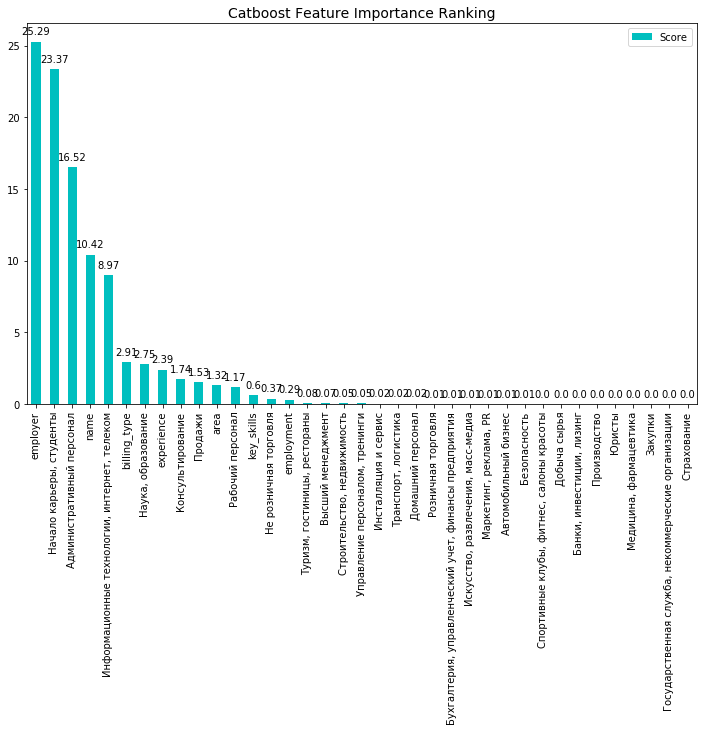

In [59]:
feature_score = cat_feature_importances(cat.cat, X_train, y_train, indexes)

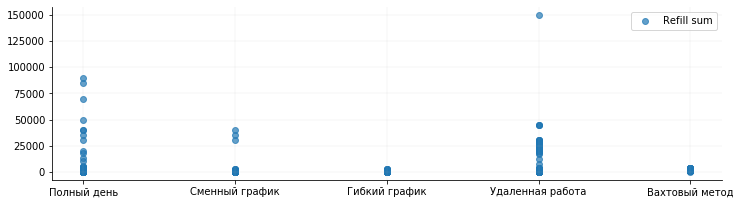